In [1]:
!pip install qiskit-nature --upgrade


[notice] A new release of pip available: 23.1.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [3]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit.circuit.library import EfficientSU2
import numpy as np
from qiskit.utils import algorithm_globals
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator


In [4]:
global qubit_mapper

def prepare_qubit_hamiltonian(molecule, bond_distance):
    global qubit_mapper
    # Specify driver
    atom_string = "; ".join([f"{atom} {x} {y} {z}" for atom, (x, y, z) in molecule])
    driver = PySCFDriver(
        atom=atom_string,
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()

    # Specify active space transformation
    active_space_trafo = ActiveSpaceTransformer(
        num_electrons=problem.num_particles, num_spatial_orbitals=3
    )

    # Transform the electronic structure problem
    problem = active_space_trafo.transform(problem)

    # Construct the parity mapper
    qubit_mapper = ParityMapper(problem.num_particles)

    # Convert to qubit Hamiltonian
    qubit_op = qubit_mapper.map(problem.second_q_ops()[0])

    return qubit_op, problem

In [5]:
def atom_input():
    # Get user input for each atom
    element_1 = input("Enter the first element (e.g., 'Li'): ")
    element_2 = input("Enter the second element (e.g., 'H'): ")

    # Get bond distance
    bond_distance = float(input("Enter the bond distance in Angstrom (e.g., 2.5): "))

    # Create the atom string
    atom_string = f"{element_1} 0 0 0; {element_2} 0 0 {bond_distance}"

    return atom_string, bond_distance

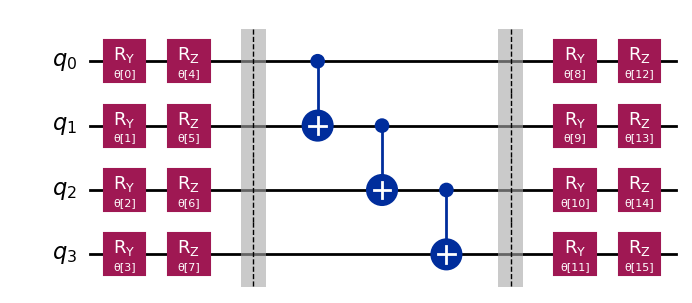

In [6]:
ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="linear", insert_barriers=True)
ansatz.decompose().draw("mpl", style="iqx")

In [7]:
# User inputs the atom and bond distance
atom_string, bond_distance = atom_input()
 
# Parse the atom string to create a molecule structure
molecule = [(atom.split()[0], (float(atom.split()[1]), float(atom.split()[2]), float(atom.split()[3]))) for atom in atom_string.split("; ")]

# Prepare the qubit Hamiltonian and problem
qubit_hamiltonian, problem = prepare_qubit_hamiltonian(molecule, bond_distance)

Enter the first element (e.g., 'Li'):  Li
Enter the second element (e.g., 'H'):  H
Enter the bond distance in Angstrom (e.g., 2.5):  2.5


In [8]:
# Classical Solver
np_solver = NumPyMinimumEigensolver()
np_groundstate_solver = GroundStateEigensolver(qubit_mapper, np_solver)
np_result = np_groundstate_solver.solve(problem)
print("Classical Solver Result:", np_result)

Classical Solver Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.408630641972
  - computed part:      -8.408630641972
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.635012653104
> Total ground state energy (Hartree): -7.773617988868
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  4.72431531]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  6.450258072775]
    - computed part:      [0.0  0.0  6.450258072775]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  -1.725942762775]  Total: 1.725942762775
                 (debye): [0.0  0.0  -4.3869085123]  Total: 4.3869085123
 


In [10]:
optimizer = SPSA(maxiter=100)
initial_point = np.random.random(ansatz.num_parameters)

In [11]:
estimator = Estimator()
local_vqe = VQE(
    estimator,
    ansatz,
    optimizer,
    initial_point=initial_point,
)
local_vqe_groundstate_solver = GroundStateEigensolver(qubit_mapper, local_vqe)
local_vqe_result = local_vqe_groundstate_solver.solve(problem)

In [12]:
print(local_vqe_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.138171674883
  - computed part:      -8.138171674883
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.635012653104
> Total ground state energy (Hartree): -7.503159021779
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.998 S: 0.520 S^2: 0.790 M: 0.001
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  4.72431531]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.219087575708]
    - computed part:      [0.0  0.0  0.219087575708]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  4.505227734292]  Total: 4.505227734292
                 (debye): [0.0  0.0  11.451145613682]  Total: 11.451145613682
 


In [13]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(group="open")  # replace by your runtime provider

backend = provider.get_backend("ibmq_qasm_simulator")  # select a backend that supports the runtime

/tmp/ipykernel_552/1501249856.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()
